## AI Hub 데이터를 활용한 KoGPT2 학습

<font color="red">이전 실습 파일에서 aihub_text.csv 파일 데이터 전처리를 하고 해당 파일로 실습을 진행합니다.

실습 중 다음의 오류가 발생한다면 colab 런타임을 재실행 해주세요.
NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968
</font>

<img src="https://aihub.or.kr/web-nas/aihub21/files/editor/2022/06/13dabc7c0e4042e5a7d6c23c3f7422ef.png">

* https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=582
* https://huggingface.co/skt/kogpt2-base-v2
* https://github.com/SKT-AI/KoGPT2

In [4]:
# HuggingFace transformer 패키지 설치
!pip install -U -qq transformers

In [20]:
# GPU 사용 여부 확인
# 'cuda:0', 'cpu'
import torch

torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

## 사전 학습 모델 로드
* model_ckpt = "skt/kogpt2-base-v2":
    * model_ckpt 변수에는 KoGPT2의 체크포인트 경로를 지정합니다. "skt/kogpt2-base-v2"는 사전학습된 KoGPT2 모델 중 기본(베이스) 버전을 의미합니다.
* tokenizer = PreTrainedTokenizerFast.from_pretrained(model_ckpt, ...)
    * PreTrainedTokenizerFast.from_pretrained() 함수를 사용하여 미리 학습된 KoGPT2의 토크나이저를 불러옵니다.
    * bos_token, eos_token, unk_token, pad_token, mask_token을 지정하여 특수 토큰들을 설정합니다. `<s>, </s>, <unk>, <pad>, <mask>`가 순서대로 각각 지정되었습니다.
* model = GPT2LMHeadModel.from_pretrained(model_ckpt)
    * GPT2LMHeadModel.from_pretrained() 함수를 사용하여 미리 학습된 KoGPT2의 언어 모델을 불러옵니다.

In [6]:
# KoGPT2 tokenizer, model 불러오기
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel

model_ckpt = "skt/kogpt2-base-v2"
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    model_ckpt,
    bos_token='<s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>')


model = GPT2LMHeadModel.from_pretrained(model_ckpt)
model

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

## 텍스트 파일 로드

In [7]:
# pandas
import pandas as pd
df = pd.read_csv("aihub_text.csv")
df.shape

(1000, 2)

In [8]:
df.head()

,article,summary
0,바이든 미국 대통령과 시진핑 중국 주석이 첫 정상회담을 했다. 미중 갈등이 심화된 ...,미중 갈등이 심화된 가운데 바이든 대통령과 시진핑 주석의 첫 정상회담이 열리자 전 ...
1,이회창 전 한나라당 총재가1997년과2002년 대선을 복기(復棋)했다면JP(김종필)...,JP와의 연대로 충청권 지지세를 확산할 것을 호소하는 당료들의 호소가 있었으나 이 ...
2,이 같은 발언은 특히 집권당인 민자당의 계파 갈등과 맞물려 공화계(JP 세력)의 거...,JP는 호적상 69세로 1992년 대선 패배 후 정계 은퇴를 선언했던 DJ가 정계 ...
3,브라질 ‘좌파의 대부‘ 룰라 전 대통령을 그린 넷플릭스 다큐 영화 ’위기의 민주주의...,문 대통령은 경남 양산에 농지가 포함된 땅을 퇴임 후 사저용으로 구입했지만 농지를 ...
4,한나라당 이명박 후보는 김영삼(YS) 전 대통령과 측근 세력의 지지를 이끌어냈다. ...,1992년 총선을 앞두고 YS에 의해 영입되어 정치권에 입문한 한나라당의 이 후보는...


In [9]:
# 상위 아티클과 요약문 보기
raw_data = df
for i in raw_data[:5].index:
    print(raw_data.loc[i, "article"])
    print("-------------")

바이든 미국 대통령과 시진핑 중국 주석이 첫 정상회담을 했다. 미중 갈등이 심화된 가운데 열린 회담이라 전 세계가 이목을 집중했다. 화상으로 진행된 회담은 미국시간으로 15일 오후 7시 50분쯤, 중국시간으로 16일 오전 8시 50분쯤 시작했다.
두 정상은 모두발언에서 상호 간 협력의 필요성을 강조한 후 본론에 들어갔다. 바이든 대통령은 “미국과 중국의 지도자로서의 책임은 양국 관계가 공개적인 충돌로 바뀌지 않게 하는 것”이라고 말했다. 그러면서 “우리는 양국 국민뿐만 아니라 세계에 대해서도 책임이 있다”면서 “각국은 규칙에 따라 행동해야 하며 미국은 미국의 가치를 따를 것”이라고 했다. 이와 함께 인권에서 인도·태평양 이슈에 이르기까지 미국이 우려하는 분야에 대해 시 주석과 논의할 것이라고 말했다.
바이든 발언 후 입은 연 시 주석은 “현재 미·중 양국 발전은 모두 결정적 단계에 와 있고 인류의 지구촌은 많은 도전에 직면해 있다”면서 “미·중은 세계 2대 경제 대국이자 유엔 안전보장이사회 상임이사국으로서 소통과 협력을 강화해야 한다”라고 했다. 그러면서 “양국은 자국 내 일을 잘 처리하는 동시에 국제적인 책임도 져야 하고 인류 평화와 발전의 위대한 사업을 공동 추진해야 한다”면서 “이는 양국과 양국 국민 공동의 바람이자 미·중 양국 지도자의 공동의 사명”이라고 했다.
시 주석은 “중국과 미국은 서로 존중하고 평화롭게 공존하고 협력해서 윈윈해야 한다”면서도 “중·미가 각각 발전을 촉진하고 평화롭고 안정적인 국제 환경을 유지해야 한다”며 미국의 간섭과 개입을 경계하는 목소리도 냈다.

-------------
이회창 전 한나라당 총재가1997년과2002년 대선을 복기(復棋)했다면JP(김종필)를 우선 떠올렸을 것 같다.
대선 판세가 갈수록 악화되고 있었기 때문이었다.
이 후보의 지지율이 김대중 새정치국민회의 후보는 물론,당내 경선에서 패한 뒤 탈당해 출마한 이인제 후보에게도 밀려나 있을 때였다.
그는석 달 전 신한국당 후보로 확정됐으나 당내경선 주자였던‘9룡’들 

## 데이터셋 로드

* SummaryDataset 클래스:
    * tokenizer: 텍스트 데이터를 토큰화하기 위해 사용되는 토크나이저입니다. 이 토크나이저는 Hugging Face의 Transformers 라이브러리에서 불러온 KoGPT2의 토크나이저입니다.
    * raw_data: 원시 데이터셋 입니다.
    * max_len: 각 데이터의 최대 길이를 정의하는 변수입니다. 생성된 토큰 시퀀스가 이 길이를 초과하면 최대 길이로 자르게 됩니다.
    * data: 토큰화된 데이터를 저장하는 리스트입니다.

* `__init__` 메서드:
    * 클래스 객체가 생성될 때 호출되는 초기화 메서드입니다.
    * max_len, tokenizer, SEP_CHARS, data 등의 멤버 변수를 초기화하고 _load_and_build 메서드를 호출하여 데이터셋을 구성합니다.

* `_load_and_build` 메서드:
    * 데이터셋을 로드하고 토큰화하여 전처리하는 메서드입니다.
    * 텍스트가 최대 길이인 max_len보다 길다면, 최대 길이에 맞게 자르고 토큰 시퀀스를 구성합니다.
    * 텍스트가 최대 길이보다 짧다면, 부족한 부분을 패딩 토큰으로 채워서 토큰 시퀀스를 구성합니다.

* `__len__` 메서드:
    * 데이터셋의 총 샘플 개수를 반환하는 메서드입니다. len(dataset) 형태로 호출되며, len(dataset.data)와 같은 결과를 반환합니다.

* `__getitem__` 메서드:
    * 데이터셋의 인덱스에 해당하는 샘플을 반환하는 메서드입니다. dataset[idx] 형태로 호출되며, dataset.data[idx]와 같은 결과를 반환합니다. 이때, 데이터는 PyTorch의 텐서로 반환됩니다.

In [10]:
from torch.utils.data import Dataset, DataLoader

class SummaryDataset(Dataset):
    def __init__(self, tokenizer, raw_data, max_len=500):
        # tokenizer, max_len, SEP_CHARS, data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.SEP_CHARS = " TL;DR "
        self.data = self._load_and_build(raw_data)

    def _process_row(self, row):
        """
        기사와 요약을 토크나이징하고, 토큰 길이가 max_len을 초과하지 않도록 조정합니다.
        토크나이징된 기사와 요약 사이에 구분자(SEP_CHARS)를 끼워 넣습니다.
        필요한 경우 패딩을 추가하여 모든 데이터가 동일한 길이를 가지도록 합니다.
        """
        tokenized_article = self.tokenizer.encode(row["article"])
        tokenized_summary = self.tokenizer.encode(row["summary"])
        tokenized_sep_chars = self.tokenizer.encode(self.SEP_CHARS)

        total_length = len(tokenized_article) + len(tokenized_sep_chars) + len(tokenized_summary) + 1

        if total_length > self.max_len:
            tokenized_article = tokenized_article[:self.max_len - total_length]

        padding_length = self.max_len - len(tokenized_article) - len(tokenized_sep_chars) - len(tokenized_summary) - 1
        return torch.tensor(tokenized_article
                            + tokenized_sep_chars
                            + tokenized_summary
                            + [self.tokenizer.eos_token_id]
                            + ([self.tokenizer.pad_token_id] * padding_length)
                            )

    def _load_and_build(self, raw_data):
        self.data = raw_data.apply(self._process_row, axis=1).tolist()
        return self.data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
raw_data.head()

,article,summary
0,바이든 미국 대통령과 시진핑 중국 주석이 첫 정상회담을 했다. 미중 갈등이 심화된 ...,미중 갈등이 심화된 가운데 바이든 대통령과 시진핑 주석의 첫 정상회담이 열리자 전 ...
1,이회창 전 한나라당 총재가1997년과2002년 대선을 복기(復棋)했다면JP(김종필)...,JP와의 연대로 충청권 지지세를 확산할 것을 호소하는 당료들의 호소가 있었으나 이 ...
2,이 같은 발언은 특히 집권당인 민자당의 계파 갈등과 맞물려 공화계(JP 세력)의 거...,JP는 호적상 69세로 1992년 대선 패배 후 정계 은퇴를 선언했던 DJ가 정계 ...
3,브라질 ‘좌파의 대부‘ 룰라 전 대통령을 그린 넷플릭스 다큐 영화 ’위기의 민주주의...,문 대통령은 경남 양산에 농지가 포함된 땅을 퇴임 후 사저용으로 구입했지만 농지를 ...
4,한나라당 이명박 후보는 김영삼(YS) 전 대통령과 측근 세력의 지지를 이끌어냈다. ...,1992년 총선을 앞두고 YS에 의해 영입되어 정치권에 입문한 한나라당의 이 후보는...


In [12]:
dataset = SummaryDataset(tokenizer, raw_data, max_len=600)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
dataloader

In [13]:
# 첫 번째 배치 가져오기
first_batch = next(iter(dataloader))
# 가져온 배치 출력
first_batch

tensor([[ 9022,  9281,  7191,  ...,     3,     3,     3],
        [16330,  8148,  9697,  ...,     3,     3,     3],
        [ 9322, 17910, 37755,  ...,     3,     3,     3],
        [12484, 10513, 32724,  ...,     3,     3,     3]])

<Axes: >

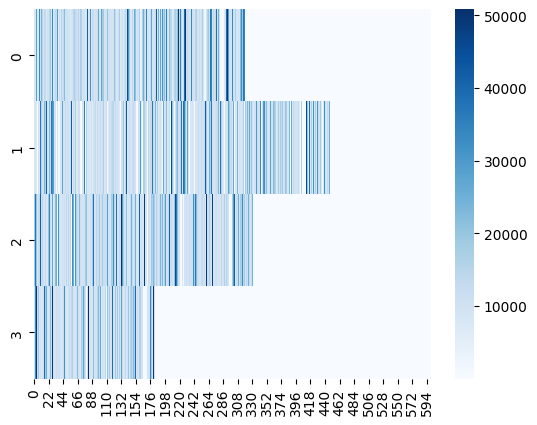

In [14]:
# 첫 번째 배치 heatmap 시각화
import seaborn as sns
sns.heatmap(first_batch, cmap="Blues")

## 학습

In [15]:
#  모델의 어떤 부분이 가장 많은 메모리를 사용하는지 식별
# print(torch.cuda.memory_summary())

In [16]:
# GPU 캐시를 비워 모델에서 사용할 수 있는 메모리를 확보할 수 있습니다.
# torch.cuda.empty_cache()

In [17]:
# model

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [23]:
EPOCHS = 3

model = model.to(device).train()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# epoch > dataloader > torch.set_grad_enabled()
for epoch in range(EPOCHS):
    for idx, batch in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            batch = batch.to(device)
            output = model(batch, labels=batch)
            loss = output[0]
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                print("epoch: {}, step: {:3d}, loss: {:.3f}".format(epoch+1, idx, loss))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


epoch: 1, step:   0, loss: 7.090
epoch: 1, step: 100, loss: 2.652
epoch: 1, step: 200, loss: 2.371
epoch: 2, step:   0, loss: 1.479
epoch: 2, step: 100, loss: 1.958
epoch: 2, step: 200, loss: 1.474
epoch: 3, step:   0, loss: 1.769
epoch: 3, step: 100, loss: 1.745
epoch: 3, step: 200, loss: 1.338


## 생성에 사용할 입력 문서 확인

In [28]:
# 샘플 문서
sample_idx = 0
sample_text = df.loc[sample_idx, "article"]

# 샘플 문서 + " TL;DR "
sample_text = sample_text + " TL;DR "

# 입력 값을 tokenize
tokenized_sample = tokenizer.encode(sample_text, return_tensors="pt")
tokenized_sample = tokenized_sample.to(device)
tokenized_sample

tensor([[12096,  7283,  9528, 41931,  9039,  8265,  8701,  9522,  9046, 12304,
          9877, 11574, 38960, 25218,  9121,  8243, 24492,  9327, 11100,  9513,
         13363, 24124,  9131,  9034, 28781,  9018, 13261, 11312, 13872,  9192,
         10123, 28814, 24124,  8135,  9528, 10785,  9021, 13467, 21734,  9247,
          7888, 10759,  7671,  8325,   387,  9522, 10785,  9021, 17244, 26098,
          9253,  7888, 10759,  7671,  8325, 10472,  7258,  9040, 10283,  9432,
          7601,  8008,  9023, 10873,  9226,  9696, 11033, 23583, 20028,  9133,
          9269, 14541, 17545,  9016, 12096,  7283, 20684,  9640,  7584, 14517,
         11226, 17286, 11349, 44443, 22443, 13198, 14628,  9090, 12940,  7426,
         10923,  8263, 13656,  9277, 32239,  9383,  9135, 13872, 49366,  9640,
         30903, 22443,  9888, 11314,  9554, 19601, 17496, 32437,  9019, 15910,
          9149,  9640,  6825, 11554, 35477,  9161, 10446,  9685, 11584, 20674,
         10772, 13889, 43267, 32239,  9383, 25218,  

## 생성
* repetition_penalty
    * 정의: repetition_penalty는 모델이 이전에 생성한 토큰을 반복하는 것을 억제하는 데 사용됩니다.
    * 작동 방식: 이 매개변수는 이미 생성된 토큰의 확률을 인위적으로 감소시켜, 모델이 같은 단어나 구를 반복적으로 생성하는 것을 방지합니다. 값이 1보다 크면 반복되는 토큰의 확률이 감소하고, 1이면 영향을 주지 않습니다.
* no_repeat_ngram_size
    * 정의: no_repeat_ngram_size는 생성된 텍스트에서 n-gram의 반복을 방지합니다.
    * 작동 방식: 이 매개변수는 지정된 크기(n)의 n-gram이 생성된 텍스트 내에서 반복되는 것을 방지합니다. 예를 들어, no_repeat_ngram_size=2로 설정하면 동일한 2-gram이 생성된 텍스트 내에서 반복되지 않도록 합니다.
* top-k 샘플링
    * 정의: top-k 샘플링은 모델이 다음 토큰을 예측할 때 가능성이 높은 상위 k개의 토큰 중에서 무작위로 선택하는 방법입니다.
    * 작동 방식: 모델이 다음 토큰에 대한 확률 분포를 계산한 후, 가장 높은 확률을 가진 상위 k개의 토큰을 선택합니다. 그런 다음 이 k개의 토큰 중 하나를 무작위로 선택하여 텍스트를 생성합니다.
    * 목적: top-k 샘플링은 생성된 텍스트의 다양성을 보장하면서도, 너무 낮은 확률을 가진 토큰을 배제하여 품질을 유지합니다.
* Top-p (Nucleus) 샘플링
    * 정의: top-p 샘플링은 확률 분포의 누적 확률이 p 이상이 되는 최소한의 토큰 집합을 선택하는 방법입니다.
    * 작동 방식: 먼저 모델이 다음 토큰에 대한 확률 분포를 계산합니다. 그런 다음 높은 확률의 토큰부터 순차적으로 추가하면서, 누적 확률이 p 이상이 되는 순간의 토큰 집합을 선택합니다. 이 집합 내에서 토큰이 무작위로 선택됩니다.
    * 목적: top-p 샘플링은 다양성과 품질 사이의 균형을 맞추는 데 효과적입니다. top-k와 달리, p 값에 따라 선택되는 토큰의 수가 동적으로 변경됩니다.

* temperature
    * 정의: temperature는 생성 과정에서 확률 분포의 '온도'를 조절하여 결과의 무작위성과 예측 가능성을 조절합니다.
    * 작동 방식: 낮은 temperature 값(예: 0.7)은 더 예측 가능하고 일관된 텍스트를 생성하도록 합니다. 반면 높은 값(예: 1 이상)은 더 다양하고 예측하기 어려운 텍스트를 생성합니다. temperature는 확률 분포를 '평탄화'하거나 '날카롭게' 만듦으로써 선택의 다양성을 조절합니다.


In [30]:
# 학습한 모델에 입력
model.eval()

output = model.generate(
    tokenized_sample,
    max_length=2000,               # 생성할 텍스트의 최대 길이
    repetition_penalty=5.0,        # 반복 패널티
    no_repeat_ngram_size=2,        # 반복되는 n-gram 크기 제한
    top_k=50,                      # top-k 샘플링
    top_p=0.95,                    # top-p 샘플링 (nucleus sampling)
    temperature=0.5,               # 생성 다양성 조절
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    use_cache=True
)

# 출력 값에 포함된 입력 값 부분을 제외하고 출력
output_decode = tokenizer.decode(output[0][len(tokenized_sample[0]):-1])
output_decode

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


'중국은 미국에 대한 책임을 인정하는 대가로 선진 그룹인 두 명에게 러브콜이 제안됐다고 한다.'

In [31]:
df.loc[sample_idx, "summary"]

'미중 갈등이 심화된 가운데 바이든 대통령과 시진핑 주석의 첫 정상회담이 열리자 전 세계의 이목이 집중됐고 두 정상은 상호 간 협력의 필요성을 강조했다.'

## ROUGE-N (N-gram Co-occurrence Statistics)

* ROUGE-N은 생성된 요약과 참조 요약 간의 N-gram 일치를 측정합니다.
    * 가장 일반적인 것은 ROUGE-1(단일 단어 일치)과 ROUGE-2(2-gram 일치)입니다.
    * ROUGE-N 스코어는 정밀도(Precision), 재현율(Recall), F1 스코어의 세 가지 값을 제공합니다.
* ROUGE-L (Longest Common Subsequence):
    * ROUGE-L은 생성된 요약과 참조 요약 간의 최장 공통 부분 수열(Longest Common Subsequence)을 측정합니다.
    * 이 메트릭은 단어의 순서를 고려하여 요약의 질을 평가합니다.
* ROUGE-S:
    * ROUGE-S(또는 ROUGE-SU)는 단어 순서가 덜 중요한 경우에 사용되며,2-gram이지만 단어 간에 다른 단어들이 삽입될 수 있습니다.


* ROUGE(Rouge-Oriented Understudy for Gisting Evaluation) 스코어를 직접 계산하기 위해서는 생성된 요약과 참조 요약 간의 n-gram 일치를 계산해야 합니다.

* ROUGE-N 스코어 계산 방법
ROUGE-N 스코어는 참조 요약과 생성된 요약 간의 n-gram 오버랩을 측정합니다. ROUGE-1은 단일 단어(1-gram)에 대한 오버랩을, ROUGE-2는 두 단어 쌍(2-gram)에 대한 오버랩을 측정합니다.

In [33]:
def ngram(token_list, n):
    return set(zip(*[token_list[i:] for i in range(n)]))

def rouge_n_score(candidate, reference, n=1):
    candidate_ngrams = ngram(candidate.split(), n)
    reference_ngrams = ngram(reference.split(), n)
    overlap_ngrams = candidate_ngrams.intersection(reference_ngrams)
    return len(overlap_ngrams) / len(candidate_ngrams), len(overlap_ngrams) / len(reference_ngrams)

def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def rouge_score(candidate, reference):
    # ROUGE-1 스코어 계산
    precision_1, recall_1 = rouge_n_score(candidate, reference, n=1)
    f1_score_1 = calculate_f1_score(precision_1, recall_1)
    # ROUGE-2 스코어 계산
    precision_2, recall_2 = rouge_n_score(candidate, reference, n=2)
    f1_score_2 = calculate_f1_score(precision_2, recall_2)

    print(f"ROUGE-1: Precision: {precision_1}, Recall: {recall_1}, F1: {f1_score_1}")
    print(f"ROUGE-2: Precision: {precision_2}, Recall: {recall_2}, F1: {f1_score_2}")


# 예시 텍스트
candidate = "산책을 하기 좋은 날씨는 맑고 화창한 날입니다."
# reference = "산책을 하기 좋은 날씨는 맑고 화창한 날입니다."
reference = "맑고 화창한 날은 산책하기 좋은 날씨입니다."

print(ngram(candidate, 1))
print(ngram(reference, 1))
rouge_score(candidate, reference)

{('.',), ('다',), ('기',), ('맑',), ('책',), ('고',), ('니',), ('을',), ('는',), ('하',), ('한',), ('날',), ('창',), (' ',), ('입',), ('화',), ('은',), ('좋',), ('산',), ('씨',)}
{('한',), ('.',), ('날',), ('창',), ('책',), ('고',), ('다',), ('기',), ('화',), ('은',), (' ',), ('좋',), ('니',), ('맑',), ('산',), ('입',), ('씨',), ('하',)}
ROUGE-1: Precision: 0.42857142857142855, Recall: 0.5, F1: 0.4615384615384615
ROUGE-2: Precision: 0.16666666666666666, Recall: 0.2, F1: 0.1818181818181818


## 생성한 텍스트의 ROUGE 점수 측정

In [37]:
candidate = output_decode
print(candidate)
reference = raw_data.loc[sample_idx, "summary"]
print(reference)

중국은 미국에 대한 책임을 인정하는 대가로 선진 그룹인 두 명에게 러브콜이 제안됐다고 한다.
미중 갈등이 심화된 가운데 바이든 대통령과 시진핑 주석의 첫 정상회담이 열리자 전 세계의 이목이 집중됐고 두 정상은 상호 간 협력의 필요성을 강조했다.


In [38]:
print(ngram(candidate, 1))
print(ngram(reference, 1))
rouge_score(candidate, reference)

{('콜',), ('.',), ('로',), ('러',), ('다',), ('진',), ('제',), ('미',), ('안',), ('임',), ('그',), ('됐',), ('책',), ('고',), ('을',), ('국',), ('인',), ('에',), ('는',), ('하',), ('정',), ('한',), ('명',), ('게',), ('이',), (' ',), ('두',), ('룹',), ('중',), ('브',), ('가',), ('선',), ('대',), ('은',)}
{('목',), ('했',), ('필',), ('령',), ('.',), ('조',), ('세',), ('다',), ('진',), ('미',), ('주',), ('과',), ('상',), ('됐',), ('심',), ('바',), ('든',), ('집',), ('갈',), ('시',), ('강',), ('고',), ('회',), ('석',), ('자',), ('계',), ('협',), ('을',), ('등',), ('담',), ('호',), ('정',), ('첫',), ('리',), ('핑',), ('의',), ('력',), ('운',), ('간',), ('이',), ('된',), ('요',), (' ',), ('통',), ('두',), ('중',), ('데',), ('전',), ('가',), ('열',), ('대',), ('화',), ('은',), ('성',)}
ROUGE-1: Precision: 0.07692307692307693, Recall: 0.045454545454545456, F1: 0.05714285714285715
ROUGE-2: Precision: 0.0, Recall: 0.0, F1: 0.0


## 다른 거대 모델에 비해 낮은 성능을 갖는 이유
* 모델 크기와 복잡성: 일반적으로, 더 큰 모델(더 많은 매개변수를 가진 모델)은 더 작은 모델보다 더 많은 양의 데이터를 학습하고, 더 복잡한 패턴을 인식할 수 있습니다. 따라서, 거대한 LLMs는 종종 더 작은 모델보다 더 우수한 성능을 보입니다.

* 학습 데이터: 모델의 성능은 사용된 학습 데이터의 양과 질에 크게 의존합니다. 더 다양하고 방대한 데이터셋으로 학습된 모델은 일반적으로 더 좋은 성능을 나타냅니다.

* 사전 학습 및 미세 조정: 많은 대형 언어 모델들은 먼저 대규모 데이터셋에서 사전 학습된 후, 특정 작업에 대해 미세 조정됩니다. 사전 학습과 미세 조정 과정의 효율성이 모델 성능에 큰 영향을 미칩니다.

* 아키텍처의 차이: 모델의 아키텍처 또한 성능에 영향을 줍니다. 변형된 Transformer 구조, 새로운 어텐션 메커니즘, 레이어 정규화 방법 등은 성능에 큰 차이를 만들 수 있습니다.

* 최적화 및 하이퍼파라미터 조정: 학습 과정에서 사용되는 최적화 기법과 하이퍼파라미터(학습률, 배치 크기 등)의 설정은 모델의 최종 성능에 중요한 역할을 합니다.

* 작업 특이성: 특정 모델이 특정 작업에 대해 더 높은 성능을 보이는 경우가 있습니다. 예를 들어, 어떤 모델은 자연어 이해(NLU)에서 뛰어난 반면, 다른 모델은 자연어 생성(NLG)에서 더 좋은 성능을 보일 수 있습니다.

* 업데이트와 유지 관리: 지속적인 업데이트와 유지 관리는 모델 성능을 지속적으로 개선하는 데 중요합니다. 최신 연구 결과나 기술의 적용이 성능 향상에 기여할 수 있습니다.